### Group Member List
Name, Student ID

LIANG Haohong, 3036364268

Liu Xiaorong, 3036353477

Deng Shuxin, 3036359586

In [1]:
# install fastparquet via system call
# !pip3 install fastparquet
# !pip3 install statsmodels 
# !pip3 install matplotlib

import fastparquet 
import pandas as pd, os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
dir = 'data/'
df = pd.read_parquet(dir + 'hw2_mfin7037_data.parquet')
# start the data in 1994, before which there's some weird stuff
df = df.query("date>='1994-01-01'")
# remember to fitler the data
df.head()

,permno,date,ret,intraday_ret_month,overnight_ret_month,mcap_lag1,prc_lag1,mom_intraday,mom,mom_overnight,mcap_bin
148,10094.0,1994-01-31,0.181818,-0.234356,0.543560,42515.000,5.500,-0.307430,-0.087011,0.229986,4.0
149,10094.0,1994-02-28,-0.115385,0.222005,-0.276094,50245.000,6.500,-0.923227,-0.646627,0.286166,5.0
150,10094.0,1994-03-31,-0.152174,0.187957,-0.286318,44447.500,5.750,-1.428256,-0.712195,0.725624,4.0
151,10094.0,1994-04-29,-0.076923,0.236076,-0.253220,37756.875,4.875,-1.398879,-0.834798,0.564079,4.0
152,10094.0,1994-05-31,0.027778,-0.138717,0.193312,34852.500,4.500,-0.764079,-0.640503,0.123572,4.0


#### Question 1

information events happen during market hours and outside of market hours:

1, Earning Announcements:
  For avoiding unstable volatility during the trading hours, the Earning Announcements usually announced outside market hours to give the time for investors to process the information.

2, Macroeconomic Announcements:
  For provding some important information that may affect the trading decisions, so it usually announced during market hours or before market hours.


why would macro announcements maWer for individual stocks?
macro announcements including employment data, inflation data, economc growth data and consumer confidence and so on. Therefore, if there is a change in interest rate, which more likely affect valuation models, such as the DCF model, when interst rates rising will lead to higher discount rates and lower stock valuations. Data like GDP, unemployment rate, optimistic data can boost market sentiment and drive stock prices higher, if non-farm payrolls are strong, inverstors more likely be more confident about the economic recovery, driving the market and individual stocks higher. 

#### Question 2

In [3]:
description = df[['mom_intraday', 'mom_overnight', 'mom']].describe()
print("Descriptive statistical results:")
print(description)

Descriptive statistical results:
       mom_intraday  mom_overnight           mom
count  1.681488e+06   1.681001e+06  1.671976e+06
mean  -5.036289e-02   7.490227e-03 -2.178160e-02
std    5.786294e-01   4.867831e-01  3.924463e-01
min   -1.989288e+01  -3.039382e+01 -1.053870e+01
25%   -2.152428e-01  -1.336102e-01 -1.719058e-01
50%    9.127390e-03   1.398969e-02  1.481509e-02
75%    1.916950e-01   1.588196e-01  1.723000e-01
max    3.006532e+01   1.781343e+01  4.218667e+00


In [4]:
correlation_matrix = df[['mom_intraday', 'mom_overnight', 'mom']].corr()
print("The correlation of intraday, overnight momentum and regular momentum:\n")
print(correlation_matrix)

The correlation of intraday, overnight momentum and regular momentum:

               mom_intraday  mom_overnight       mom
mom_intraday       1.000000      -0.691953  0.591998
mom_overnight     -0.691953       1.000000  0.105443
mom                0.591998       0.105443  1.000000


#### Question 4

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Filter data
def filter_data(df):
    df['mcap_quantile'] = df.groupby('date')['mcap_lag1'].rank(pct=True)
    df = df[df['mcap_quantile'] > 0.2]  # Exclude the bottom 20%
    df = df[df['prc_lag1'] >= 5]  # Exclude stocks with prices below 5
    return df.drop(columns=['mcap_quantile'])

In [6]:
# Generate bins and pnl datasets
def generate_bins_and_pnl(df, col):
    df['bin'] = apply_quantiles(df, col, bins=10)
    
    # Calculate equal-weighted (EW) returns
    bins_df = df.groupby(['date', 'bin']).agg({
        'ret': 'mean',
        'intraday_ret_month': 'mean',
        'overnight_ret_month': 'mean'
    }).reset_index()
    bins_df.columns = ['date', 'bin', 'ew', 'ew_intraday', 'ew_overnight']
    
    # Calculate market-cap-weighted (VW) returns
    df['total_mcap'] = df.groupby('date')['mcap_lag1'].transform('sum')
    df['vw'] = df['ret'] * df['mcap_lag1'] / df['total_mcap']
    df['vw_intraday'] = df['intraday_ret_month'] * df['mcap_lag1'] / df['total_mcap']
    df['vw_overnight'] = df['overnight_ret_month'] * df['mcap_lag1'] / df['total_mcap']
    
    vw_df = df.groupby(['date', 'bin']).agg({
        'vw': 'sum',
        'vw_intraday': 'sum',
        'vw_overnight': 'sum'
    }).reset_index()
    
    # Merge EW and VW data
    bins_df = bins_df.merge(vw_df, on=['date', 'bin'])
    
    # Calculate long-short portfolio returns (EW and VW)
    pnl_df = df.groupby('date').agg({
        'ret': 'mean',
        'intraday_ret_month': 'mean',
        'overnight_ret_month': 'mean'
    }).reset_index()
    pnl_df.columns = ['date', 'ew', 'ew_intraday', 'ew_overnight']

    pnl_df['vw'] = df.groupby('date')['vw'].sum().values
    pnl_df['vw_intraday'] = df.groupby('date')['vw_intraday'].sum().values
    pnl_df['vw_overnight'] = df.groupby('date')['vw_overnight'].sum().values

    return {'bins': bins_df, 'pnl': pnl_df}

# Filter data
filtered_data = filter_data(df)

In [9]:
def produce_table(input_data, subsetting=lambda df: df):
    """
    Combines portfolio data from 'bins' and 'pnl', computes summary statistics
    (mean returns multiplied by 100 and one-sample t-test statistics) for each portfolio,
    and returns a pivoted table for portfolios 1..10 and a long-short portfolio.
    
    Parameters:
        input_data (dict): Dictionary with keys:
            - 'bins': a DataFrame with columns ['date','bin','ew','vw',
                      'ew_intraday','vw_intraday','ew_overnight','vw_overnight']
            - 'pnl': a DataFrame with columns ['date','ew','vw',
                      'ew_intraday','vw_intraday','ew_overnight','vw_overnight']
                      (this will be used to compute the long-short portfolio)
        subsetting (function): A function to subset/modify the combined DataFrame.
                               Defaults to the identity function.
    
    Returns:
        pd.DataFrame: A table where each row corresponds to a return measure (e.g., EW, VW, etc.)
                      with the first row showing the mean (×100, rounded to 3 decimals) and the second
                      row showing the t-statistic (in parentheses). The long-short portfolio is labeled "10-1".
    """
    # Extract the required columns from each DataFrame.
    bins_df = input_data['bins'][['date', 'bin', 'ew', 'vw', 
                                  'ew_intraday', 'vw_intraday', 
                                  'ew_overnight', 'vw_overnight']].copy()
    pnl_df = input_data['pnl'][['date', 'ew', 'vw', 
                                'ew_intraday', 'vw_intraday', 
                                'ew_overnight', 'vw_overnight']].copy()
    # Designate the pnl data as portfolio "11" (which later will be renamed to "10-1")
    pnl_df['bin'] = 11

    # Combine the two datasets and apply any subsetting
    combined = pd.concat([bins_df, pnl_df], ignore_index=True)
    combined = subsetting(combined)

    # List of return measure columns
    cols = ['ew', 'vw', 'ew_intraday', 'vw_intraday', 'ew_overnight', 'vw_overnight']

    # Function to compute mean multiplied by 100 and rounded to 3 decimals
    def meanna(x):
        return round(x.mean() * 100, 3)

    # Compute group-wise means by portfolio (bin)
    s1 = combined.groupby('bin')[cols].agg(meanna).reset_index()
    s1_melt = s1.melt(id_vars='bin', var_name='variable', value_name='value')
    s1_pivot = s1_melt.pivot(index='variable', columns='bin', values='value').reset_index()
    s1_pivot['order'] = 1

    # Function to compute one-sample t-test statistic (null: mean=0), rounded to 3 decimals and wrapped in parentheses.
    def ttesting(x):
        x = x.dropna()
        if len(x) == 0:
            return None
        stat, _ = ttest_1samp(x, popmean=0)
        return f"({round(stat, 3)})"

    # Compute group-wise t-statistics by portfolio (bin)
    s2 = combined.groupby('bin')[cols].agg(ttesting).reset_index()
    s2_melt = s2.melt(id_vars='bin', var_name='variable', value_name='value')
    s2_pivot = s2_melt.pivot(index='variable', columns='bin', values='value').reset_index()
    s2_pivot['order'] = 2

    # Combine the mean and t-statistic tables
    table = pd.concat([s1_pivot, s2_pivot], ignore_index=True)
    table = table.sort_values(by=['variable', 'order'])
    # For rows with t-statistics (order 2), clear the 'variable' name
    table.loc[table['order'] == 2, 'variable'] = ''
    table = table.drop(columns=['order'])

    # Format the variable names: uppercase and replace underscores with spaces
    table['variable'] = table['variable'].str.upper().str.replace('_', ' ', regex=False)
    table = table.rename(columns={'variable': 'Portfolio'})

    # Rename portfolio 11 to "10-1" (i.e. the long-short portfolio)
    if 11 in table.columns:
        table = table.rename(columns={11: '10-1'})
    
    # Ensure that only portfolios 1 through 10 and the long-short ("10-1") remain.
    valid_portfolios = list(range(1, 11)) + ['10-1']
    cols_to_keep = ['Portfolio'] + [col for col in table.columns if col in valid_portfolios]
    table = table[cols_to_keep]

    return table


# --- Helper: Apply quantiles within each date group ---
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)

In [10]:
# Generate momentum table
momentum_input = generate_bins_and_pnl(filtered_data, 'mom')
momentum_table = produce_table(momentum_input)

# Generate momentum_intraday table
momentum_intraday_input = generate_bins_and_pnl(filtered_data, 'mom_intraday')
momentum_intraday_table = produce_table(momentum_intraday_input)

# Generate momentum_overnight table
momentum_overnight_input = generate_bins_and_pnl(filtered_data, 'mom_overnight')
momentum_overnight_table = produce_table(momentum_overnight_input)


In [11]:
print("Momentum Table:")
momentum_table

Momentum Table:


bin,Portfolio,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1
0,EW,0.091,0.684,0.838,0.925,0.964,1.051,0.964,1.028,1.052,1.369,0.904
6,,(0.201),(2.022),(2.849),(3.536),(3.854),(4.299),(3.924),(3.816),(3.48),(3.365),(3.139)
1,EW INTRADAY,-0.796,0.637,0.924,1.073,0.994,1.011,0.797,0.687,0.446,-0.009,0.545
7,,(-2.037),(2.189),(3.678),(4.826),(4.814),(5.139),(4.039),(3.23),(1.86),(-0.028),(2.329)
2,EW OVERNIGHT,1.581,0.495,0.231,0.154,0.189,0.255,0.404,0.595,0.905,1.781,0.711
8,,(7.886),(3.182),(1.649),(1.158),(1.424),(1.937),(3.04),(4.123),(5.563),(8.583),(4.926)
3,VW,0.001,0.054,0.066,0.076,0.107,0.109,0.12,0.116,0.093,0.105,0.85
9,,(0.064),(2.011),(2.196),(2.496),(3.848),(3.813),(3.928),(3.549),(2.663),(3.408),(3.531)
4,VW INTRADAY,-0.028,0.041,0.047,0.061,0.07,0.058,0.049,0.006,-0.032,-0.038,0.229
10,,(-1.664),(2.066),(1.916),(2.494),(2.904),(2.528),(1.976),(0.23),(-1.14),(-1.576),(1.209)


In [12]:
print("\nMomentum Intraday Table:")
momentum_intraday_table


Momentum Intraday Table:


bin,Portfolio,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1
0,EW,0.128,0.718,0.974,1.038,0.99,0.985,1.011,1.032,0.96,1.143,0.904
6,,(0.274),(2.063),(3.26),(3.825),(3.887),(3.968),(4.171),(4.034),(3.454),(3.391),(3.139)
1,EW INTRADAY,-2.206,-0.286,0.313,0.54,0.639,0.738,0.918,1.017,1.235,2.724,0.545
7,,(-5.448),(-0.978),(1.248),(2.468),(3.035),(3.723),(4.696),(4.968),(5.503),(9.27),(2.329)
2,EW OVERNIGHT,3.18,1.386,0.911,0.671,0.493,0.391,0.26,0.208,0.035,-0.737,0.711
8,,(13.883),(8.243),(6.199),(4.813),(3.762),(2.951),(1.979),(1.494),(0.234),(-3.986),(4.926)
3,VW,0.003,0.037,0.092,0.108,0.11,0.129,0.121,0.101,0.091,0.051,0.85
9,,(0.177),(1.346),(2.801),(3.367),(3.714),(4.224),(3.995),(3.413),(3.225),(2.775),(3.531)
4,VW INTRADAY,-0.068,-0.04,0.01,0.037,0.038,0.064,0.068,0.048,0.051,0.024,0.229
10,,(-3.985),(-1.805),(0.365),(1.451),(1.532),(2.463),(2.737),(2.08),(2.31),(1.758),(1.209)


In [13]:
print("\nMomentum Overnight Table:")
momentum_overnight_table


Momentum Overnight Table:


bin,Portfolio,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1
0,EW,0.602,0.857,0.966,1.005,1.026,0.979,1.026,1.03,0.945,0.538,0.904
6,,(1.995),(3.009),(3.558),(3.867),(3.945),(3.819),(3.744),(3.45),(2.703),(1.238),(3.139)
1,EW INTRADAY,3.395,1.617,1.237,0.984,0.754,0.464,0.236,-0.097,-0.651,-2.3,0.545
7,,(11.964),(6.594),(5.391),(4.576),(3.555),(2.226),(1.069),(-0.409),(-2.311),(-6.481),(2.329)
2,EW OVERNIGHT,-2.036,-0.49,-0.064,0.204,0.438,0.675,1.013,1.404,1.982,3.661,0.711
8,,(-11.277),(-3.395),(-0.465),(1.539),(3.216),(5.07),(7.192),(9.035),(11.057),(15.384),(4.926)
3,VW,0.027,0.05,0.087,0.115,0.093,0.124,0.122,0.124,0.074,0.029,0.85
9,,(2.22),(2.144),(3.294),(4.01),(3.015),(4.143),(3.66),(3.7),(2.354),(1.206),(3.531)
4,VW INTRADAY,0.057,0.082,0.108,0.108,0.057,0.05,0.007,-0.021,-0.103,-0.115,0.229
10,,(5.773),(4.441),(5.338),(4.616),(2.35),(1.954),(0.257),(-0.771),(-3.921),(-5.732),(1.209)


#### Question Answer:

Based on the provided tables, we can analyze the predictive relationships as follows:

### **1. Predictive Power of Intraday Momentum**

- **Intraday momentum** **predicts intraday future returns** positively and **total returns** as well. The **negative correlation** with **overnight returns** indicates that high intraday momentum can lead to lower overnight performance. The t-values confirm these results as statistically significant.

---

### **2. Predictive Power of Overnight Momentum**

- **Overnight momentum** shows a **strong predictive effect on overnight returns**, with significant positive t-values. However, it **negatively predicts intraday returns**, which is also statistically significant. The correlation with **total returns** is positive but weaker than its correlation with overnight returns.

---

### **Key Summary**
| Momentum Type       | Predicts Intraday Returns? | Predicts Overnight Returns? | Predicts Total Returns? |
|---------------------|----------------------------|------------------------------|--------------------------|
| **Intraday**        | ✅ Strong Positive        | ✅ Strong Negative           | ✅ Positive      |
| **Overnight**       | ✅ Strong Negative          | ✅ Strong Positive         | ✅ Positive      |
  

In [14]:
# --- Helper: Apply quantiles within each date group ---
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)


In [15]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
import statsmodels.formula.api as smf


def routine_pnl(dta, plot=False):
    """
    Computes portfolio returns (EW/VW) by bin, optionally creates two plots 
    (mean returns by bin and cumulative pnl), runs a series of OLS regressions, 
    and returns a dictionary with outputs.
    
    Assumes dta contains columns: date, bin, ret, mcap_lag1, 
    intraday_ret_month, overnight_ret_month.
    
    Parameters:
      dta   : pd.DataFrame
              Input data.
      plot  : bool, default False
              If True, plots are created; if False, they are suppressed.
    
    Returns:
      dict with keys:
          'p1'             : Axes for decile plot (or None if plot==False)
          'pnl_curve'      : Axes for cumulative pnl plot (or None if plot==False)
          'factor_loadings': Dictionary of regression results
          'pnl'            : DataFrame of pnl calculations
          'bins'           : DataFrame of computed bin returns
    """
    # Ensure date is datetime
    dta = dta.copy()
    dta['date'] = pd.to_datetime(dta['date'])
    
    # Helper: Weighted mean
    def weighted_mean(x, w):
        return np.average(x, weights=w)
    
    # Compute portfolio returns by date and bin
    bins = (dta.groupby(['date', 'bin'])
            .apply(lambda g: pd.Series({
                'ew': g['ret'].mean(),
                'vw': weighted_mean(g['ret'], g['mcap_lag1']),
                'ew_intraday': g['intraday_ret_month'].mean() if 'intraday_ret_month' in g.columns else np.nan,
                'vw_intraday': weighted_mean(g['intraday_ret_month'], g['mcap_lag1']) if 'intraday_ret_month' in g.columns else np.nan,
                'ew_overnight': g['overnight_ret_month'].mean() if 'overnight_ret_month' in g.columns else np.nan,
                'vw_overnight': weighted_mean(g['overnight_ret_month'], g['mcap_lag1']) if 'overnight_ret_month' in g.columns else np.nan,
            }))
            .reset_index())
    
    # Create decile plot (collapsed across dates) if plotting is requested
    if plot:
        bins_collapsed = bins.groupby('bin')[['ew','vw']].mean().reset_index()
        fig1, ax1 = plt.subplots()
        ax1.plot(bins_collapsed['bin'], bins_collapsed['ew'], label='EW', marker='')
        ax1.plot(bins_collapsed['bin'], bins_collapsed['vw'], label='VW', marker='')
        ax1.set_xlabel('Bin')
        ax1.set_ylabel('Return')
        ax1.set_title('Mean Portfolio Returns by Bin')
        ax1.legend()
        plt.tight_layout()
    else:
        ax1 = None
    
    # Compute long-short pnl using the extreme bins (assume bin 1 and max(bin))
    max_bin = bins['bin'].max()
    selected = bins[bins['bin'].isin([1, max_bin])].copy()
    selected['weight'] = selected['bin'].apply(lambda x: -1 if x == 1 else 1)
    pnl = (selected.groupby('date')
           .apply(lambda g: pd.Series({
               'ew': (g['weight'] * g['ew']).sum(),
               'vw': (g['weight'] * g['vw']).sum(),
               'ew_intraday': (g['weight'] * g['ew_intraday']).sum() if 'ew_intraday' in g.columns else np.nan,
               'vw_intraday': (g['weight'] * g['vw_intraday']).sum() if 'vw_intraday' in g.columns else np.nan,
               'ew_overnight': (g['weight'] * g['ew_overnight']).sum() if 'ew_overnight' in g.columns else np.nan,
               'vw_overnight': (g['weight'] * g['vw_overnight']).sum() if 'vw_overnight' in g.columns else np.nan,
           })).reset_index())
    pnl = pnl.sort_values('date')
    pnl['cumvw'] = (1 + pnl['vw']).cumprod() - 1
    pnl['cumew'] = (1 + pnl['ew']).cumprod() - 1
    
    # Create cumulative pnl plot if plotting is requested
    if plot:
        fig2, ax2 = plt.subplots()
        ax2.plot(pnl['date'], pnl['cumew'], label='EW')
        ax2.plot(pnl['date'], pnl['cumvw'], label='VW')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Return')
        ax2.set_title('Cumulative PnL Over Time')
        ax2.legend()
        plt.tight_layout()
    else:
        ax2 = None
    
    # Minimal regressions for demonstration, not done tho
    formulas = [
        'ew ~ 1',
        'vw ~ 1',
        'ew ~ 0',  # dummy formula if needed
    ]
    regs = {}
    for bin_val in sorted(bins['bin'].unique()):
        data_bin = bins[bins['bin'] == bin_val]
        for fml in formulas:
            key = f'bin {bin_val} fml {fml}'
            try:
                model = smf.ols(formula=fml, data=data_bin).fit()
            except Exception as e:
                model = None
                print(f"Regression failed for bin {bin_val} with formula '{fml}': {e}")
            regs[key] = model
            
    # Return outputs in a dictionary
    return {
        'p1': ax1,                # decile plot (or None)
        'pnl_curve': ax2,         # cumulative pnl plot (or None)
        'factor_loadings': regs,  # regression results
        'pnl': pnl,               # pnl table
        'bins': bins              # bins table (with computed returns)
    }


#### Question 5

In [16]:
# Create bins for intraday momentum and overnight momentum (5 bins each)
bin_df = df.copy()
bin_df['intraday_bin'] = pd.qcut(bin_df['mom_intraday'], 5, labels=False) + 1
bin_df['overnight_bin'] = pd.qcut(bin_df['mom_overnight'], 5, labels=False) + 1

# Group by year and month
bin_df['year_month'] = pd.to_datetime(bin_df['date']).dt.to_period('M')

# Compute value-weighted and equal-weighted returns for each bin combination (5x5 grid)
def compute_monthly_returns(group):
    # Value-weighted return: weighted by mcap_bin
    value_weighted_return = (group['ret'] * group['mcap_bin']).sum() / group['mcap_bin'].sum()
    
    # Equal-weighted return: average of returns
    equal_weighted_return = group['ret'].mean()
    
    return pd.Series({
        'value_weighted_return': value_weighted_return,
        'equal_weighted_return': equal_weighted_return
    })

# Apply the computation for each combination of intraday and overnight bins
monthly_returns = bin_df.groupby(['year_month', 'intraday_bin', 'overnight_bin']).apply(
    compute_monthly_returns).reset_index()

# Pivot the data to create the 5x5 grid for both value-weighted and equal-weighted returns
value_weighted_grid = monthly_returns.pivot_table(index='intraday_bin', 
                                                  columns='overnight_bin', 
                                                  values='value_weighted_return',
                                                    aggfunc='mean')
# Pivot with clear column labels and transpose to get correct orientation
value_weighted_grid = monthly_returns.pivot_table(
    index='overnight_bin', 
    columns='intraday_bin', 
    values='value_weighted_return', 
    aggfunc='mean'
).rename_axis(index='Overnight Momentum Bin', columns='Intraday Momentum Bin')

equal_weighted_grid = monthly_returns.pivot_table(
    index='overnight_bin',
    columns='intraday_bin',
    values='equal_weighted_return',
    aggfunc='mean'
).rename_axis(index='Overnight Momentum Bin', columns='Intraday Momentum Bin')

# Display grids with formatted headers
print("Value-Weighted Return Grid (Rows: Overnight Momentum, Columns: Intraday Momentum)")
print(value_weighted_grid.reset_index().to_string(index=False))

print("\nEqual-Weighted Return Grid (Rows: Overnight Momentum, Columns: Intraday Momentum)")
print(equal_weighted_grid.reset_index().to_string(index=False))

Value-Weighted Return Grid (Rows: Overnight Momentum, Columns: Intraday Momentum)
 Overnight Momentum Bin       1.0      2.0      3.0      4.0      5.0
                    1.0  0.006053 0.003161 0.002842 0.005434 0.007782
                    2.0  0.000752 0.004371 0.007278 0.009180 0.010251
                    3.0 -0.001915 0.007530 0.009792 0.010257 0.013949
                    4.0  0.002464 0.008355 0.010178 0.011908 0.016984
                    5.0  0.001905 0.008193 0.012089 0.011331 0.016390

Equal-Weighted Return Grid (Rows: Overnight Momentum, Columns: Intraday Momentum)
 Overnight Momentum Bin      1.0      2.0      3.0      4.0      5.0
                    1.0 0.013916 0.009495 0.005735 0.006768 0.010105
                    2.0 0.006002 0.006167 0.007688 0.010108 0.011444
                    3.0 0.001745 0.007601 0.010213 0.010776 0.015672
                    4.0 0.003703 0.008641 0.011312 0.012843 0.017597
                    5.0 0.005966 0.009717 0.012640 0.013049 0.016786


C:\Users\Ben\AppData\Local\Temp\ipykernel_44308\3328143768.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_returns = bin_df.groupby(['year_month', 'intraday_bin', 'overnight_bin']).apply(


#### Question 6

In [17]:
# testing that whether intraday momentum explains returns within overnight momentum buckets 
# and reversely

def perform_regression_analysis(monthly_returns, 
                                bucket_var='overnight_bin', 
                                x_var='intraday_bin', 
                                y_var='value_weighted_return'):
    """Perform regression analysis of returns on momentum factors within specified buckets
    
    Args:
        monthly_returns: DataFrame containing monthly returns data
        bucket_var: Variable to group by (either 'intraday_bin' or 'overnight_bin')
        x_var: Momentum factor to test (opposite of bucket_var)
        y_var: Return variable to use as dependent variable
        
    Returns:
        DataFrame with regression results for each bucket
    """
    results = []
    
    # Get sorted list of unique buckets
    buckets = sorted(monthly_returns[bucket_var].unique())
    
    for bucket in buckets:
        subset = monthly_returns[monthly_returns[bucket_var] == bucket]
        
        # Run regression: returns ~ momentum factor
        model = smf.ols(f'{y_var} ~ {x_var}', data=subset).fit()
        
        results.append({
            'Bucket': bucket,
            'Coeff': model.params[x_var],
            't-stat': model.tvalues[x_var],
            'p-value': model.pvalues[x_var],
            'R-squared': model.rsquared
        })
    
    return pd.DataFrame(results)

# Create more intuitive name mapping
name_map = {
    'intraday_bin': 'Intraday',
    'overnight_bin': 'Overnight'
}

# Run analysis for both directions
forward_results = perform_regression_analysis(monthly_returns, 
                                            bucket_var='overnight_bin',
                                            x_var='intraday_bin')
reverse_results = perform_regression_analysis(monthly_returns,
                                            bucket_var='intraday_bin',
                                            x_var='overnight_bin')

# Add significance stars based on p-value
def add_significance_stars(row):
    coeff = row['Coeff']
    pval = row['p-value']
    if pval < 0.01:
        return f"{coeff:.3f}***"
    elif pval < 0.05:
        return f"{coeff:.3f}**"
    elif pval < 0.1:
        return f"{coeff:.3f}*"
    return f"{coeff:.3f}"

# Format and print both results
def format_results(results, direction):
    # Split direction into components
    direction_parts = direction.split('_within_')
    
    # Get proper names from name_map
    x_name = name_map[direction_parts[0] + '_bin']  # e.g., "intraday_bin" -> "Intraday"
    bucket_name = name_map[direction_parts[1] + '_bin']  # e.g., "overnight_bin" -> "Overnight"

    results[f'{x_name} Coeff (Significance)'] = results.apply(add_significance_stars, axis=1)
    print(f"\nRegression Results: {x_name} Momentum Explains Returns Within {bucket_name} Buckets")
    print(results[['Bucket', f'{x_name} Coeff (Significance)', 
                 't-stat', 'p-value', 'R-squared']].rename(columns={'Bucket': f'{bucket_name} Bin'})
                 .to_string(index=False, formatters={
                     't-stat': '{:.3f}'.format,
                     'p-value': '{:.4f}'.format,
                     'R-squared': '{:.4f}'.format
                 }))

# Process both directions
format_results(forward_results, 'intraday_within_overnight')
format_results(reverse_results, 'overnight_within_intraday')


Regression Results: Intraday Momentum Explains Returns Within Overnight Buckets
 Overnight Bin Intraday Coeff (Significance) t-stat p-value R-squared
           1.0                         0.001  0.440  0.6599    0.0001
           2.0                       0.002**  2.258  0.0241    0.0030
           3.0                      0.003***  3.324  0.0009    0.0064
           4.0                      0.003***  3.040  0.0024    0.0053
           5.0                       0.003**  2.276  0.0230    0.0030

Regression Results: Overnight Momentum Explains Returns Within Intraday Buckets
 Intraday Bin Overnight Coeff (Significance) t-stat p-value R-squared
          1.0                         -0.001 -0.410  0.6816    0.0001
          2.0                          0.001  1.307  0.1912    0.0010
          3.0                        0.002**  2.286  0.0224    0.0030
          4.0                          0.001  1.506  0.1322    0.0013
          5.0                        0.002**  1.965  0.0496    0.002

on average, intraday momentum can explains mostly returns within overnight momentum bucket, but overnight momentum cannot explains because of most overnight Coeffs are not significant.

In [18]:
# testing that whether returns increase monotonically with both momentum factors

def analyze_profitability_trend(return_grid):
    """Analyze if returns increase monotonically with both momentum factors"""
    # Convert grid to numpy array
    matrix = return_grid.values
    
    # Check intraday momentum effect within each overnight bin
    intraday_trend = np.all(np.diff(matrix, axis=1) > 0, axis=1)  # Check if increasing across columns
    intraday_consistency = np.mean(intraday_trend)
    
    # Check overnight momentum effect within each intraday bin
    overnight_trend = np.all(np.diff(matrix, axis=0) > 0, axis=0)  # Check if increasing across rows
    overnight_consistency = np.mean(overnight_trend)
    
    # Check diagonal growth (combined momentum)
    diagonal = np.diag(matrix)
    diagonal_growth = np.all(np.diff(diagonal) > 0)
    
    return {
        'intraday_consistency': intraday_consistency,
        'overnight_consistency': overnight_consistency,
        'diagonal_growth': diagonal_growth,
        'mean_diagonal_return': np.mean(diagonal)
    }

# Analyze both weighting schemes
vw_analysis = analyze_profitability_trend(value_weighted_grid)
ew_analysis = analyze_profitability_trend(equal_weighted_grid)

print("Value-Weighted Analysis:")
print(f"Consistent intraday momentum effect: {vw_analysis['intraday_consistency']*100:.1f}% of rows")
print(f"Consistent overnight momentum effect: {vw_analysis['overnight_consistency']*100:.1f}% of columns")
print(f"Diagonal growth: {vw_analysis['diagonal_growth']}, Mean diagonal return: {vw_analysis['mean_diagonal_return']:.4f}")

print("\nEqual-Weighted Analysis:")
print(f"Consistent intraday momentum effect: {ew_analysis['intraday_consistency']*100:.1f}% of rows")
print(f"Consistent overnight momentum effect: {ew_analysis['overnight_consistency']*100:.1f}% of columns")
print(f"Diagonal growth: {ew_analysis['diagonal_growth']}, Mean diagonal return: {ew_analysis['mean_diagonal_return']:.4f}")

# Statistical test using linear regression
model = smf.ols('value_weighted_return ~ intraday_bin * overnight_bin', data=monthly_returns).fit()
print("\nInteraction Effect Analysis:")
print(model.summary())

Value-Weighted Analysis:
Consistent intraday momentum effect: 60.0% of rows
Consistent overnight momentum effect: 20.0% of columns
Diagonal growth: False, Mean diagonal return: 0.0097

Equal-Weighted Analysis:
Consistent intraday momentum effect: 80.0% of rows
Consistent overnight momentum effect: 40.0% of columns
Diagonal growth: False, Mean diagonal return: 0.0120

Interaction Effect Analysis:
                              OLS Regression Results                             
Dep. Variable:     value_weighted_return   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.003
Method:                    Least Squares   F-statistic:                     10.92
Date:                   Thu, 27 Feb 2025   Prob (F-statistic):           3.73e-07
Time:                           20:46:25   Log-Likelihood:                 10751.
No. Observations:                   8625   AIC:                        -2.149e+04
Df Residuals:              

statistically, both momentum increase cannot increase the profitability of strategy

Value-Weighted Strategy Performance:
Total Return             3.081884
Annualized Return        0.050140
Annualized Volatility    0.376097
Sharpe Ratio             0.329829
Max Drawdown             0.783504

Equal-Weighted Strategy Performance:
Total Return            -0.691671
Annualized Return       -0.040099
Annualized Volatility    0.376975
Sharpe Ratio             0.091330
Max Drawdown             0.933221


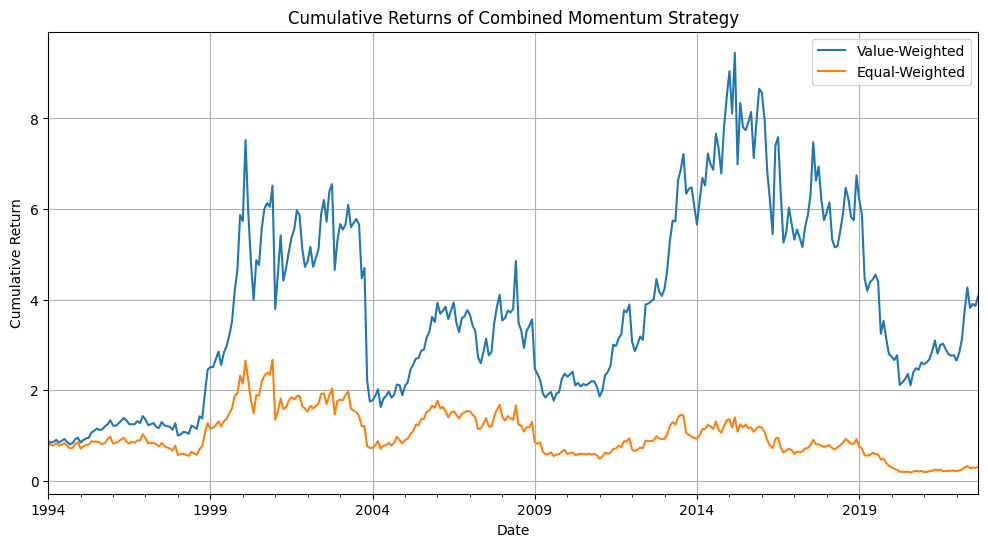


Value-Weighted Factor Exposure:
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.480
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.193
Time:                        20:46:25   Log-Likelihood:                 5840.4
No. Observations:                7239   AIC:                        -1.167e+04
Df Residuals:                    7233   BIC:                        -1.163e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.01

In [19]:
# construct strategy returns
# long highest intraday and overnight momentum, short lowest
ff5 = pd.read_parquet(dir + 'ff.five_factor.parquet')
# Convert FF5 date to datetime and create year_month index
ff5['date'] = pd.to_datetime(ff5['dt'])
ff5['year_month'] = ff5['date'].dt.to_period('M')

# Convert factors from monthly decimal to decimal (e.g. 1.0 = 100bps)
factor_cols = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']

# Set index for alignment with strategy returns
ff5 = ff5.set_index('year_month')


# Construct strategy returns (long highest both, short lowest both)
def momentum_strategy_backtest(monthly_returns, weighting='value'):
    """
    Backtests a strategy that longs highest intraday/overnight momentum
    and shorts lowest intraday/overnight momentum
    
    Parameters:
        monthly_returns: DataFrame from Question 5 analysis
        weighting: 'value' or 'equal' weighting scheme
    
    Returns:
        pd.Series of strategy returns
    """
    # Select return column based on weighting scheme
    ret_col = f'{weighting}_weighted_return' if weighting == 'value' else f'equal_weighted_return'
    
    # Create pivot table of returns
    returns_pivot = monthly_returns.pivot_table(
        index='year_month',
        columns=['intraday_bin', 'overnight_bin'],
        values=ret_col
    )
    
    # Long highest quintile (5,5), short lowest (1,1)
    long_returns = returns_pivot[(5,5)]
    short_returns = returns_pivot[(1,1)]
    
    # Handle missing values (if any bins are missing)
    strategy_returns = (long_returns.fillna(0) - short_returns.fillna(0)).dropna()
    
    return strategy_returns

# Backtest both weighting schemes
vw_strategy = momentum_strategy_backtest(monthly_returns, 'value')
ew_strategy = momentum_strategy_backtest(monthly_returns, 'equal')

# Calculate performance metrics
def calculate_metrics(returns):
    """Calculate annualized performance metrics"""
    return {
        'Total Return': (returns + 1).prod() - 1,
        'Annualized Return': (returns + 1).prod()**(12/len(returns)) - 1,
        'Annualized Volatility': returns.std() * np.sqrt(12),
        'Sharpe Ratio': returns.mean() / returns.std() * np.sqrt(12),
        'Max Drawdown': (1 - (returns + 1).cumprod() / (returns + 1).cumprod().cummax()).max()
    }

# Print performance report
print("Value-Weighted Strategy Performance:")
print(pd.Series(calculate_metrics(vw_strategy)).to_string())
print("\nEqual-Weighted Strategy Performance:")
print(pd.Series(calculate_metrics(ew_strategy)).to_string())

# Plot cumulative returns
plt.figure(figsize=(12, 6))
(vw_strategy + 1).cumprod().plot(label='Value-Weighted')
(ew_strategy + 1).cumprod().plot(label='Equal-Weighted')
plt.title('Cumulative Returns of Combined Momentum Strategy')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# Factor regression analysis
def factor_regression(strategy_returns, factors):
    """Run factor regression with Fama-French 5 factors"""
    merged = pd.merge(
        strategy_returns.reset_index(),
        factors,
        on='year_month',
        how='left'
    ).set_index('year_month')
    
    # Convert percentage returns to decimals
    factor_cols = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']
    merged[factor_cols] = merged[factor_cols] / 100
    
    # Run regression
    model = smf.ols('strategy_returns ~ mkt_rf + smb + hml + rmw + cma', 
                   data=merged.rename(columns={0: 'strategy_returns'})).fit()
    return model

# Load Fama-French factors (assuming ff5 exists)

# Run factor analysis
print("\nValue-Weighted Factor Exposure:")
vw_model = factor_regression(vw_strategy, ff5)
print(vw_model.summary())

print("\nEqual-Weighted Factor Exposure:")
ew_model = factor_regression(ew_strategy, ff5)
print(ew_model.summary())

based on the monthly return matrix, a portfolio longing the highest return bucket and shorting lowest return bucket is constructed. It performs better in valued-weighted, total return is 3.081884 and has alpha of 0.0108, suggesting a better return in combination.

#### Question 7

C:\Users\Ben\AppData\Local\Temp\ipykernel_44308\2468944764.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_returns = df_ls.groupby(['year_month', 'intraday_bin', 'overnight_bin']).apply(compute_returns).reset_index()


Value-Weighted Sharpe: 0.49
Equal-Weighted Sharpe: 0.09
Momentum Factor Sharpe: 0.66


C:\Users\Ben\AppData\Local\Temp\ipykernel_44308\2468944764.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mom_returns = df_ls.groupby(['year_month', 'mom_bin']).apply(compute_returns).reset_index()


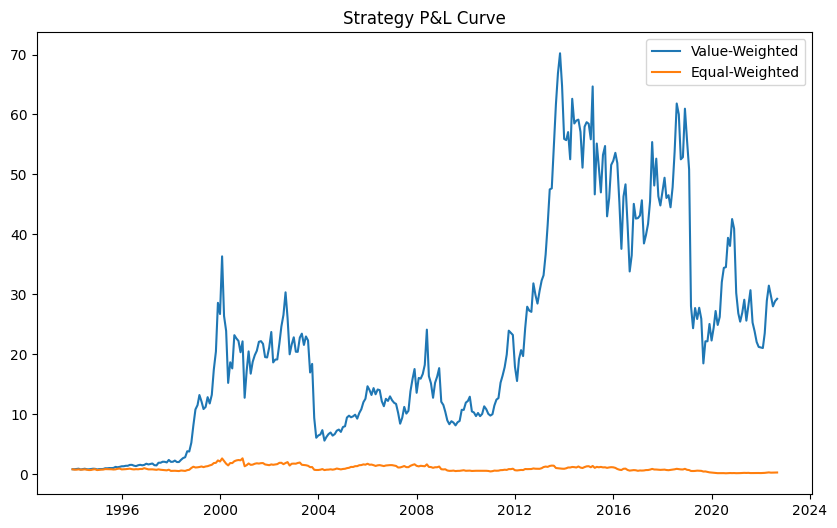

Alpha: 0.0052
                            OLS Regression Results                            
Dep. Variable:               strategy   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     145.7
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           3.33e-28
Time:                        20:46:29   Log-Likelihood:                 263.70
No. Observations:                 345   AIC:                            -523.4
Df Residuals:                     343   BIC:                            -515.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.006      

C:\Users\Ben\AppData\Local\Temp\ipykernel_44308\2468944764.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]  # Intercept is the alpha


In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df_ls = df.copy()
df_ls['date'] = pd.to_datetime(df_ls['date'])

# Create momentum quintiles
df_ls['intraday_bin'] = pd.qcut(df_ls['mom_intraday'], 5, labels=False, duplicates='drop') + 1
df_ls['overnight_bin'] = pd.qcut(df_ls['mom_overnight'], 5, labels=False, duplicates='drop') + 1
df_ls['year_month'] = df_ls['date'].dt.to_period('M')

# Compute monthly returns for each bin
def compute_returns(group):
    vw_ret = (group['ret'] * group['mcap_lag1']).sum() / group['mcap_lag1'].sum()
    ew_ret = group['ret'].mean()
    return pd.Series({'vw_ret': vw_ret, 'ew_ret': ew_ret})

monthly_returns = df_ls.groupby(['year_month', 'intraday_bin', 'overnight_bin']).apply(compute_returns).reset_index()

# Strategy returns:long 5,5; short 1,1
def get_strategy_returns(monthly_df, weighting_col):
    long = monthly_df[(monthly_df['intraday_bin'] == 5) & (monthly_df['overnight_bin'] == 5)]
    short = monthly_df[(monthly_df['intraday_bin'] == 1) & (monthly_df['overnight_bin'] == 1)]
    merged = pd.merge(long, short, on='year_month', suffixes=('_long', '_short'))
    merged['strategy'] = merged[f'{weighting_col}_long'] - merged[f'{weighting_col}_short']
    return merged.set_index('year_month')['strategy']

vw_strategy = get_strategy_returns(monthly_returns, 'vw_ret')
ew_strategy = get_strategy_returns(monthly_returns, 'ew_ret')

# Sharpe ratio
def annualized_sharpe(returns):
    return (returns.mean() / returns.std()) * np.sqrt(12)

print(f"Value-Weighted Sharpe: {annualized_sharpe(vw_strategy):.2f}")
print(f"Equal-Weighted Sharpe: {annualized_sharpe(ew_strategy):.2f}")

# Self-constructed momentum factor: long 5th quintile, short 1st quintile
df_ls['mom_bin'] = pd.qcut(df_ls['mom'], 5, labels=False, duplicates='drop') + 1
mom_returns = df_ls.groupby(['year_month', 'mom_bin']).apply(compute_returns).reset_index()

mom_long = mom_returns[mom_returns['mom_bin'] == 5].set_index('year_month')['vw_ret']
mom_short = mom_returns[mom_returns['mom_bin'] == 1].set_index('year_month')['vw_ret']
mom_factor = mom_long - mom_short

print(f"Momentum Factor Sharpe: {annualized_sharpe(mom_factor):.2f}")

# P&L curve
plt.figure(figsize=(10,6))
plt.plot(vw_strategy.index.to_timestamp(), (1 + vw_strategy).cumprod(), label='Value-Weighted')
plt.plot(ew_strategy.index.to_timestamp(), (1 + ew_strategy).cumprod(), label='Equal-Weighted')
plt.title('Strategy P&L Curve')
plt.legend()
plt.show()

# Alpha test with respect to momentum factor
combined = pd.DataFrame({
    'strategy': vw_strategy,
    'mom_factor': mom_factor
}).dropna()

X = sm.add_constant(combined['mom_factor'])
model = sm.OLS(combined['strategy'], X).fit()
alpha = model.params[0]  # Intercept is the alpha

print(f'Alpha: {alpha:.4f}')
print(model.summary())

In [21]:
combined

,strategy,mom_factor
year_month,,
1994-01,-0.143184,0.004128
1994-02,-0.006386,0.006565
1994-03,0.054962,-0.032184
1994-04,0.050055,0.043392
1994-05,-0.143571,-0.029864
...,...,...
2022-05,0.086838,0.111486
2022-06,-0.054161,0.008332
2022-07,-0.058809,-0.055846


In [22]:
FF5 = pd.read_parquet(dir + 'ff.five_factor.parquet')
FF5['year_month'] = pd.to_datetime(FF5['dt']).dt.to_period('M')

# Merge on 'year_month'
merged = FF5.merge(combined.reset_index(), on="year_month")

merged

,dt,mkt_rf,smb,hml,rmw,cma,rf,year_month,strategy,mom_factor
0,1994-01-03,-0.0045,-0.0021,0.0039,-0.0018,0.0060,0.00012,1994-01,-0.143184,0.004128
1,1994-01-04,0.0024,-0.0006,0.0016,-0.0049,0.0036,0.00012,1994-01,-0.143184,0.004128
2,1994-01-05,0.0021,0.0022,-0.0011,-0.0013,-0.0002,0.00012,1994-01,-0.143184,0.004128
3,1994-01-06,-0.0007,0.0026,-0.0022,0.0004,-0.0001,0.00012,1994-01,-0.143184,0.004128
4,1994-01-07,0.0048,-0.0011,0.0019,0.0033,-0.0003,0.00012,1994-01,-0.143184,0.004128
...,...,...,...,...,...,...,...,...,...,...
7234,2022-09-26,-0.0102,-0.0005,-0.0075,0.0017,-0.0042,0.00009,2022-09,0.014027,0.075629
7235,2022-09-27,-0.0005,0.0058,-0.0093,-0.0062,-0.0090,0.00009,2022-09,0.014027,0.075629
7236,2022-09-28,0.0215,0.0092,-0.0033,-0.0086,-0.0071,0.00009,2022-09,0.014027,0.075629
7237,2022-09-29,-0.0217,-0.0028,0.0086,0.0043,0.0050,0.00009,2022-09,0.014027,0.075629


In [23]:
# Drop rows with missing values in the regression columns
merged = merged.dropna(subset=['mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'strategy'])

# Regression to calculate alpha
X = sm.add_constant(merged[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']])
y = merged['strategy']  # Assuming 'Return' is the portfolio return

model = sm.OLS(y, X).fit()
alpha = model.params[0]  # Intercept is the alpha

print(f'Alpha: {alpha:.4f}')
print(model.summary())

Alpha: 0.0199
                            OLS Regression Results                            
Dep. Variable:               strategy   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.520
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.180
Time:                        20:46:29   Log-Likelihood:                 4245.0
No. Observations:                7239   AIC:                            -8478.
Df Residuals:                    7233   BIC:                            -8437.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0199      0.002     1

C:\Users\Ben\AppData\Local\Temp\ipykernel_44308\282295167.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]  # Intercept is the alpha


#### Question Answer
-Sharp ratio: 
 Value-Weighted Sharpe Ratio: 0.49
 Equal-Weighted Sharpe Ratio: 0.09
 Momentum Factor Sharpe Ratio: 0.66
The sharp ratio of momentum facor is the highest, performing well than equal/value weighted strategies.

-Alpha
Alpha with Respect to the Momentum Portfolio:
 The regression show that the alpha of strategy is 0.0052 with respect to the momentum portfolio, but the p-value for alpha is 0.401, greater than 0.0052, which shows that the alpha is less likely show the statistically significant.

Alpha with Respect to the Momentum Portfolio + FF5 Factors:
 The regression show that the alpha of strategy is 0.0199 with repect tot eh momentum portfolio plus the FF5 factors. The p-value 0.000 is less than 0.0199, shows that the alpha more likely show the statistically significant.

-Summary
The strategy which shorts stocks whichare low quintile of both momentum strategies, and long the high quintile of both momentum strategies perform well, especially when plus the FF5 factors. 